In [1]:
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from joblib import load, dump
from ruamel.yaml import YAML
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import h5py
import periodictable as pt
from palettable.cartocolors.sequential import SunsetDark_7

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample

from umda import paths
from umda.data import load_data, load_pipeline
from umda import training

plt.style.use("publication.mpl")

In [2]:
seed = 1215677
normalize = True
mask = False

In [3]:
state = np.random.default_rng(seed)

full_X, full_cluster_ids, tmc1_df = load_data(exclude_hydrogen=True)
embedder = load_pipeline()

tmc1_X = np.vstack([embedder.vectorize(smi) for smi in tmc1_df["SMILES"]])
tmc1_y = np.log10(tmc1_df["Column density (cm^-2)"].to_numpy())

((train_X, train_y), (test_X, test_y)), indices = training.get_molecule_split_bootstrap(
    (tmc1_X, tmc1_y), seed=seed, n_samples=800, replace=True,
    noise_scale=0.5, molecule_split=0.2, test_size=0.2
    )

X = np.vstack([train_X, test_X])
y = np.concatenate([train_y, test_y])

In [4]:
with open("model_hparams.yml") as read_file:
    hparams = YAML().load(read_file)

In [5]:
# gp_kernel = kernels.ConstantKernel() * \
#     kernels.RBF(3.0, (1e-1, 10.0)) + \
#     kernels.RationalQuadratic(200.0, 20.0, alpha_bounds=(1e-3, 5e2), length_scale_bounds=(50.0, 1e4)) * \
#         kernels.ConstantKernel() + kernels.ConstantKernel()
gp_kernel = training.get_gp_kernel()

In [6]:
base_models = {
    "linear_regression": LinearRegression(),
    "ridge": Ridge(),
    "br": BayesianRidge(lambda_1=1e4, lambda_2=1e4, tol=1e-4, alpha_1=9.8, alpha_2=0.02, alpha_init=1e-5, lambda_init=0.474),
    "svr": SVR(),
    "knn": KNeighborsRegressor(),
    "rfr": RandomForestRegressor(random_state=seed),
    "gbr": GradientBoostingRegressor(random_state=seed),
    "gpr": GaussianProcessRegressor(
        kernel=gp_kernel, random_state=seed
    )
}

models = {key: training.compose_model(value, normalize) for key, value in base_models.items()}

The code below will perform a grid search over hyperparameters, using `ShuffleSplit` cross-validation and identifying the set of hyperparameters with the lowest test error. The model is then refit to the full dataset: this is viable because we have a bootstrap dataset that minimizes the degree of overfitting. This is confirmed in the learning curves later on, which uses the models with optimized hyperparameters.

In [7]:
# generalized workflow
model_results = dict()
best_models = dict()
cv_results = dict()
cv = GroupShuffleSplit(10, test_size=0.2, random_state=seed)
# loop over models
for name in models.keys():
    model = models.get(name)
    print(f"Working on {name} now.")
    hparam = hparams.get(name)
    # only do grid search for the models with hparam specification, using the custom
    # bootstrapped CV model
    if hparam is not None:
        cv_grid = training.grid_cv_search((X, y, indices), model, hparam, seed, verbose=1, cv=cv, n_jobs=8, scoring="neg_mean_squared_error",
        )
    result, _ = training.get_best_model(model, (X, y, indices), cv)
    pred_Y = result.predict(test_X)
    mse = mean_squared_error(test_y, pred_Y)
    print(f"Model: {name} best CV score: {cv_grid.best_score_:.4e}, split test score: {mse:.2f}")
    best_models[name] = result
    cv_results[name] = cv_grid

Working on linear_regression now.
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Model: linear_regression best CV score: -2.7598e+22, split test score: 2397478131932235563008.00
Working on ridge now.
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Model: ridge best CV score: -1.1599e+00, split test score: 0.54
Working on br now.
Model: br best CV score: -1.1599e+00, split test score: 0.51
Working on svr now.
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Model: svr best CV score: -1.7446e+00, split test score: 0.48
Working on knn now.
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Model: knn best CV score: -1.3160e+00, split test score: 0.22
Working on rfr now.
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Model: rfr best CV score: -1.3396e+00, split test score: 0.53
Working on gbr now.
Fitting 10 folds for each of 1600 candidates, totalling 16000 fits
Model: gbr best CV score: -1.1500e+00, split test score: 0.

Export the cross-validation reports, which should be inspected to see which hyperparameters affect the loss the most (and which don't).

In [8]:
# export the cross-validation results
for name in models.keys():
    df = pd.DataFrame(cv_results[name].cv_results_)
    keys = ["mean_test_score", "rank_test_score"]
    keys.extend([key for key in df.keys() if "param_" in key])
    df = df[keys]
    # sort and reset the indices
    df.sort_values("rank_test_score", ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)
    # dump to CSV file
    if normalize:
        flags = "norm"
    else:
        flags = "unnorm"
    if mask:
        flags += "_mask"
    else:
        flags += "_nomask"
    df.to_csv(f"outputs/grid_search/{name}_{flags}.csv", index=False)

## Exporting the hyperparameter optimization results

This is mostly for final reporting, where we write out the best hyperparameters for each model as a YAML dictionary, with keys being the models and the values being the best hyperparameters for that model (within the search space).

In [9]:
# collect up the dictionaries for best parameters
best_param_dict = dict()
for name in models.keys():
    best_param_dict[name] = cv_results[name].best_params_
with open("outputs/grid_search/optimized_hparams.yml", "w+") as write_file:
    YAML().dump(best_param_dict, write_file)

## Dumping the best models to pickle

In [10]:
dump(best_models, "outputs/grid_search/best_models.pkl")

['outputs/grid_search/best_models.pkl']

In [11]:
best_param_dict

{'linear_regression': {'regressor__fit_intercept': True,
  'regressor__normalize': False},
 'ridge': {'regressor__alpha': 1.0,
  'regressor__fit_intercept': True,
  'regressor__normalize': True},
 'br': {'regressor__alpha': 1.0,
  'regressor__fit_intercept': True,
  'regressor__normalize': True},
 'svr': {'regressor__C': 100.0,
  'regressor__epsilon': 0.1,
  'regressor__kernel': 'rbf',
  'regressor__tol': 1e-05},
 'knn': {'regressor__metric': 'cosine',
  'regressor__n_neighbors': 30,
  'regressor__weights': 'uniform'},
 'rfr': {'regressor__n_estimators': 50},
 'gbr': {'regressor__learning_rate': 0.01,
  'regressor__min_samples_leaf': 0.3,
  'regressor__min_samples_split': 0.1,
  'regressor__n_estimators': 100,
  'regressor__subsample': 0.8},
 'gpr': {'regressor__alpha': 3e-05, 'regressor__n_restarts_optimizer': 3}}

## Making an overview plot

First compute the scatter point sizes as a function of molecular weight.

In [12]:
formulae = tmc1_df["Formula"].str.replace("+", "").str.replace("-", "").to_list()
formulae = [pt.formula(formula) for formula in formulae]

In [13]:
def calc_mass(formula):
    weight = 0
    for atom, number in formula.atoms.items():
        weight += atom.mass * number
    return weight

In [14]:
weights = np.array(list(map(calc_mass, formulae)))

In [15]:
# these are the extremely poor performing molecules by LR
tmc1_df.loc[np.abs(best_models.get("gpr").predict(tmc1_X)) <= 10.]

,Molecule,Formula,SMILES,Column density (cm^-2),DOI,Isotopologue,Upper Limit,Notes,canonical,vectors


In [16]:
colors = SunsetDark_7.mpl_colormap(np.linspace(0., 1., 8))

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


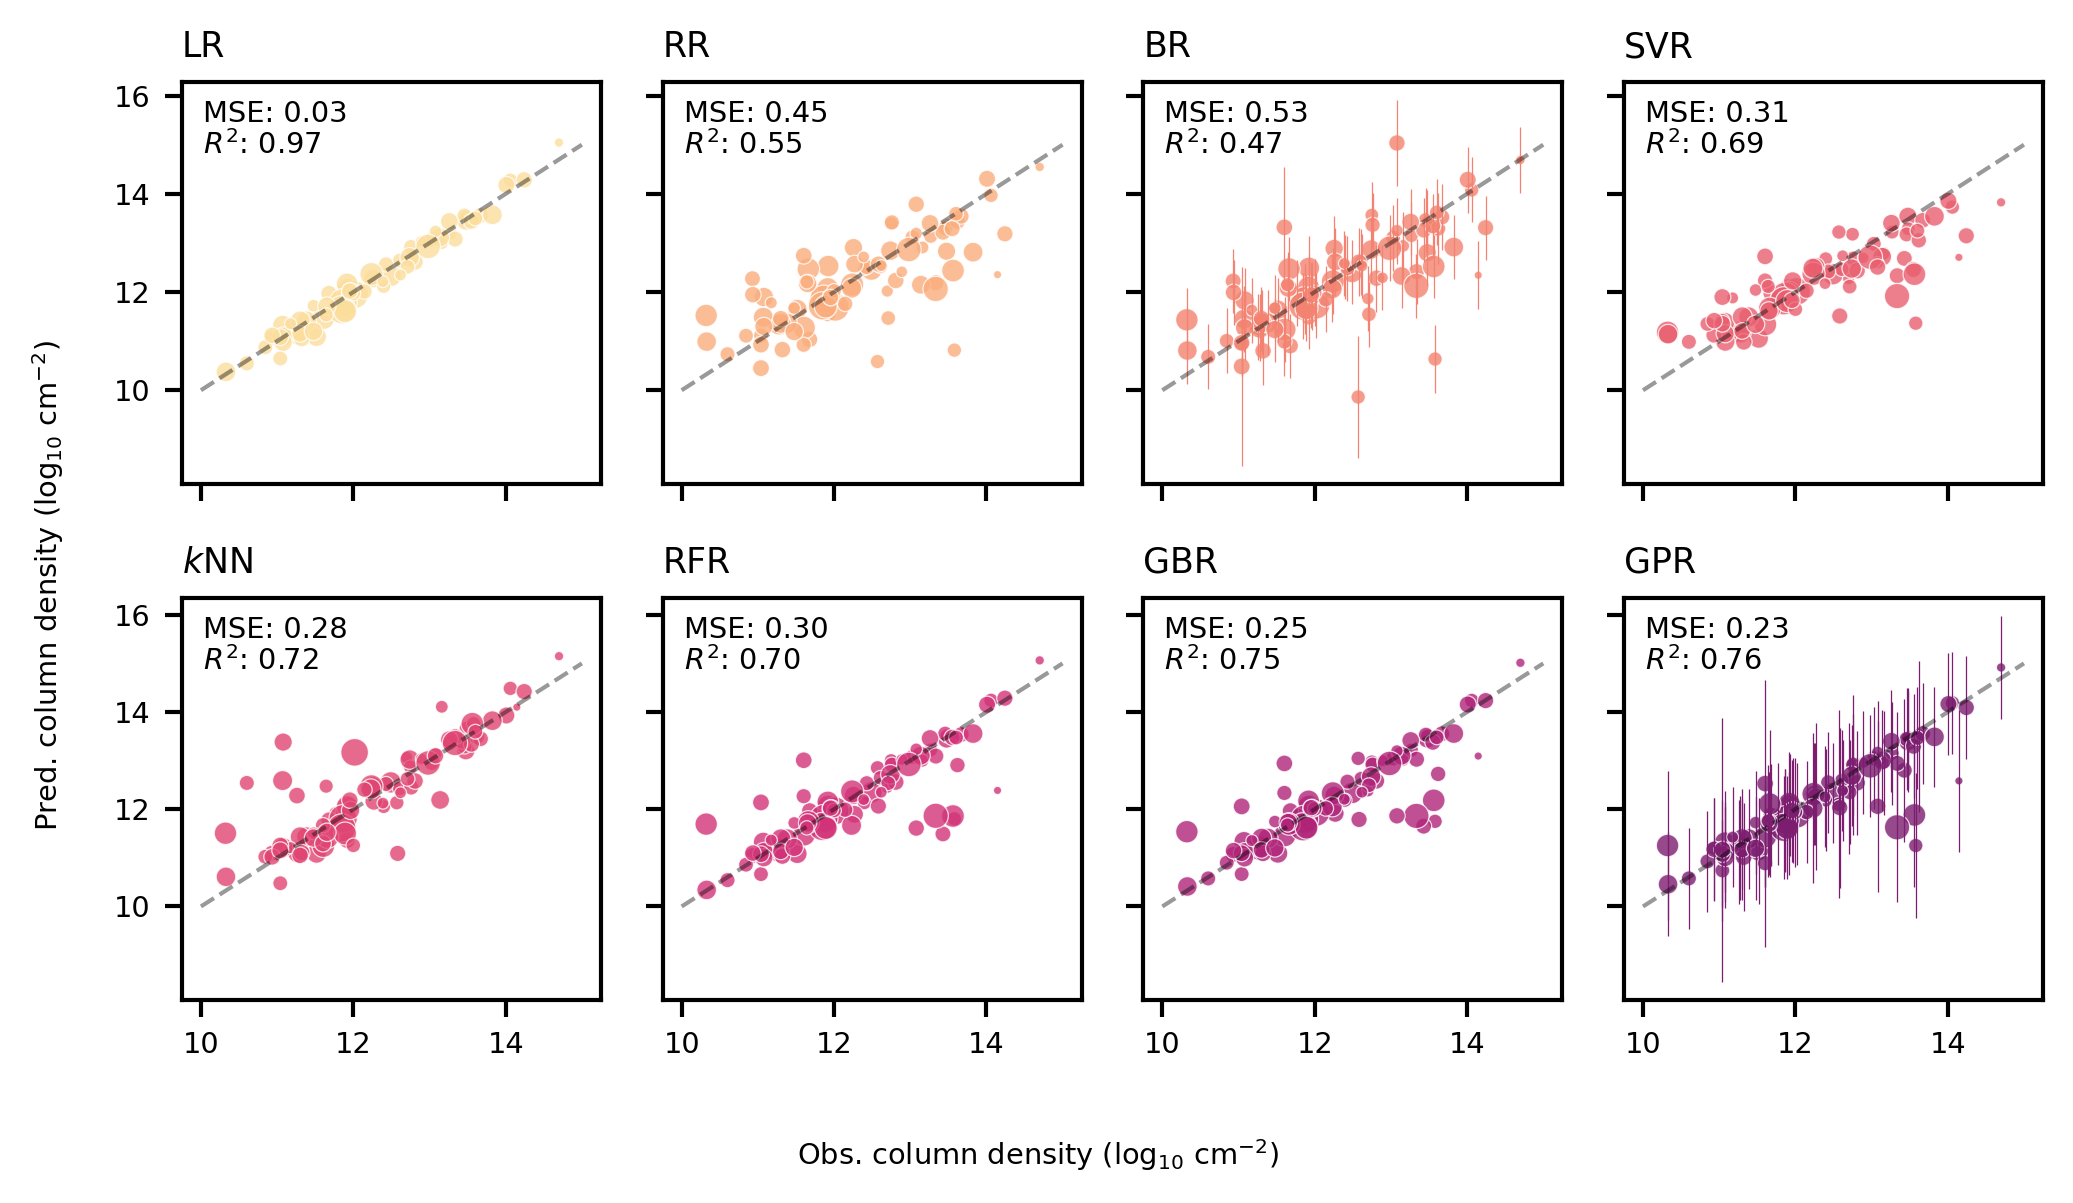

In [17]:
num_models = len(models)
formatted_names = {key: key.upper() for key in models.keys()}
formatted_names["linear_regression"] = "LR"
formatted_names["ridge"] = "RR"
formatted_names["knn"] = "$k$NN"

fig, axarray = plt.subplots(2, num_models // 2, figsize=(7, 4), sharex=True, sharey="row")

for model_name, ax, color in zip(models.keys(), axarray.flatten(), colors):
    model = best_models.get(model_name)
    # draw the ideal curve
    ax.plot(np.arange(10, 16), np.arange(10, 16), ls="--", alpha=0.4, color="k")
    # ax.hlines(0., 10., 15., ls="--", alpha=0.3)
    # for probabilistic models, get the uncertainty too
    if model_name in ["gpr", "br"]:
        pred_y, pred_std = model.predict(tmc1_X, return_std=True)
        mask = np.ones_like(tmc1_y, dtype=bool)
        ax.errorbar(tmc1_y, pred_y, yerr=pred_std, fmt="none",  elinewidth=0.3, ecolor=color)
        ax.scatter(tmc1_y, pred_y, s=0.3 * weights[mask], lw=0.3, edgecolors="w", alpha=0.8, c=color[None,:])
        # ax.errorbar(tmc1_y, np.log10(pred_y / tmc1_y), yerr=np.log10(pred_std / tmc1_y), fmt="none",  elinewidth=0.3, ecolor=color)
        # ax.scatter(tmc1_y, np.log10(pred_y / tmc1_y), lw=0.3, edgecolors="w", alpha=0.8, c=color[None,:])
    elif model_name == "linear_regression":
        pred_y = model.predict(tmc1_X)
        # filter the insane outliers
        mask = np.abs(pred_y) <= 25.
        # ax.scatter(tmc1_y[mask], np.log10(pred_y[mask] / tmc1_y[mask]), s=0.3 * weights[mask], lw=0.3, edgecolors="w", alpha=0.8, c=color[None,:])
        ax.scatter(tmc1_y[mask], pred_y[mask], s=0.3 * weights[mask], lw=0.3, edgecolors="w", alpha=0.8, c=color[None,:])
    else:
        pred_y = model.predict(tmc1_X)
        mask = np.ones_like(tmc1_y, dtype=bool)
        # ax.scatter(tmc1_y, np.log10(pred_y / tmc1_y), s=0.3 * weights[mask], lw=0.3, edgecolors="w", alpha=0.8, c=color[None,:])
        ax.scatter(tmc1_y, pred_y, s=0.3 * weights[mask], lw=0.3, edgecolors="w", alpha=0.8, c=color[None,:])
    r2 = r2_score(tmc1_y[mask], pred_y[mask])
    mse = mean_squared_error(tmc1_y[mask], pred_y[mask])
    # ax.set(xlim=[9.5, 15.5], ylim=(9.5, 15.5))
    real_name = formatted_names.get(model_name)
    ax.set_title(f"{real_name}", loc="left")
    # if model_name != "linear_regression":
    ax.text(0.05, 0.9, f"MSE: {mse:.2f}", fontsize="x-small", transform=ax.transAxes)
    ax.text(0.05, 0.82, f"$R^2$: {r2:.2f}", fontsize="x-small", transform=ax.transAxes)
    # ax.set(xlim=[9.5, 15.5], ylim=(9.5, 15.5))
    # ax.set(ylim=[-0.13, 0.13])
fig.supxlabel("Obs. column density ($\log_{10}$ cm$^{-2}$)", fontsize="x-small")
fig.supylabel("Pred. column density ($\log_{10}$ cm$^{-2}$)",  fontsize="x-small")
fig.tight_layout()
fig.savefig("outputs/grid_search/regression_plot.pdf", dpi=150)

## Learning curves for every model

This uses the optimal hyperparameter models

Running model linear_regression
Running model ridge
Running model br
Running model svr
Running model knn
Running model rfr
Running model gbr
Running model gpr


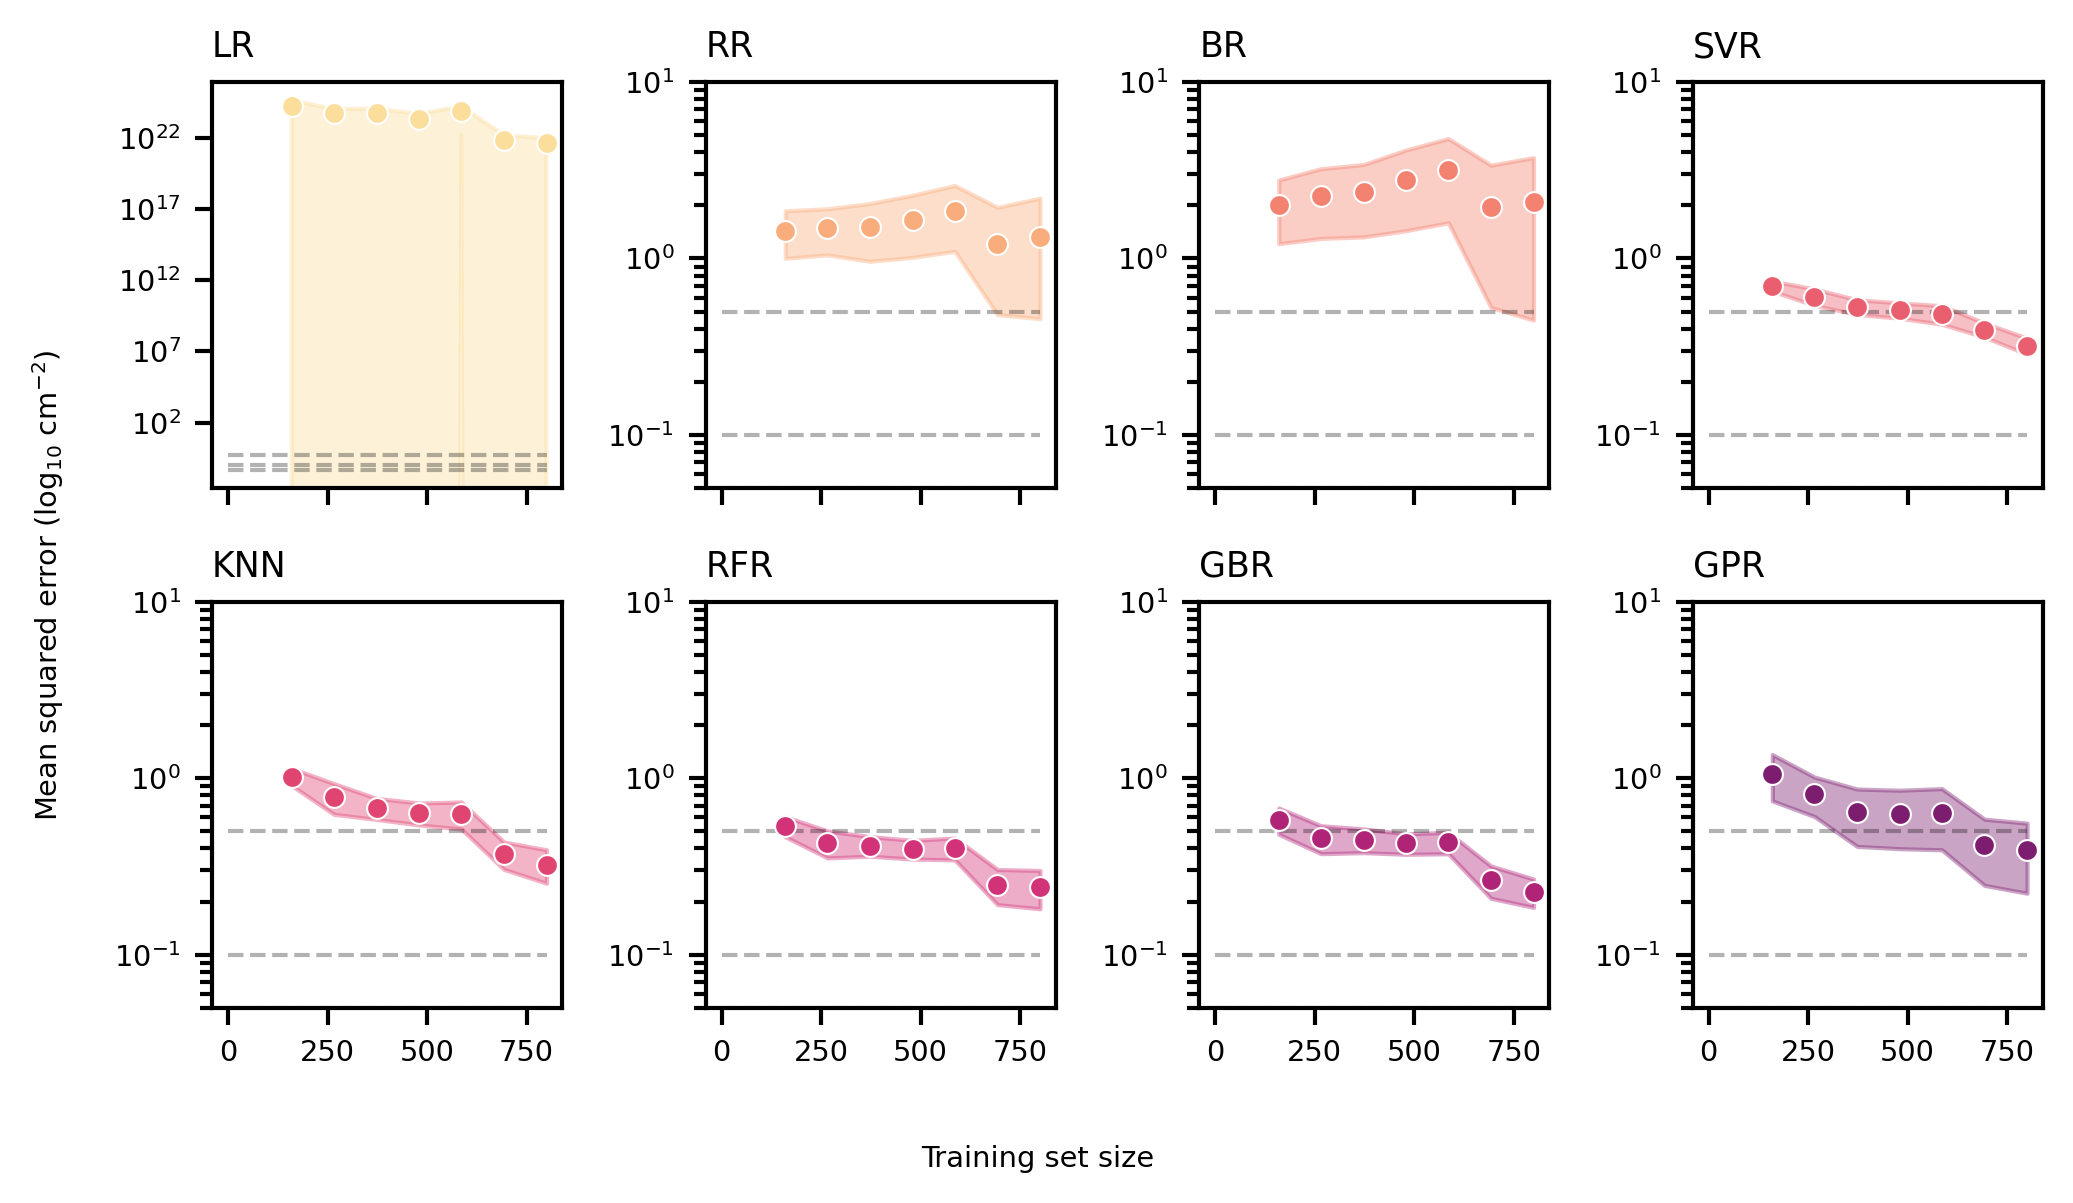

In [18]:
num_models = len(models)
formatted_names = {key: key.upper() for key in models.keys()}
formatted_names["linear_regression"] = "LR"
formatted_names["ridge"] = "RR"

train_sizes = np.linspace(0.2, 1., 7)

fig, axarray = plt.subplots(2, num_models // 2, figsize=(7, 4), sharex=True)

for model_name, ax, color in zip(models.keys(), axarray.flatten(), colors):
    model = best_models.get(model_name)
    print(f"Running model {model_name}")
    # do the learning curve based on the real TMC-1 data
    steps, error = training.custom_learning_curve(
        model, (X, y, indices), (tmc1_X, tmc1_y), train_sizes, cv
        )
    mean_val, std_val = np.abs(error.mean(axis=1)), error.std(axis=1)
    # plot the learning curves up with CV uncertainty
    ax.plot(steps, mean_val, "o", color=color[None,:], mec="w", mew=0.5)
    ax.fill_between(steps, mean_val+std_val, mean_val-std_val, alpha=0.4, color=color)
    ax.hlines([5e-2, 1e-1, 5e-1], 0., steps.max(), ls="--", alpha=0.3)
    if model_name != "linear_regression":
        ax.set(ylim=[5e-2, 10.])
    ax.set(yscale="log")
    ax.set_title(formatted_names.get(model_name), loc="left")
fig.supxlabel("Training set size", fontsize="x-small")
fig.supylabel("Mean squared error ($\log_{10}$ cm$^{-2}$)", fontsize="x-small")
fig.tight_layout()
fig.savefig("outputs/grid_search/learning_curve.pdf", dpi=150)